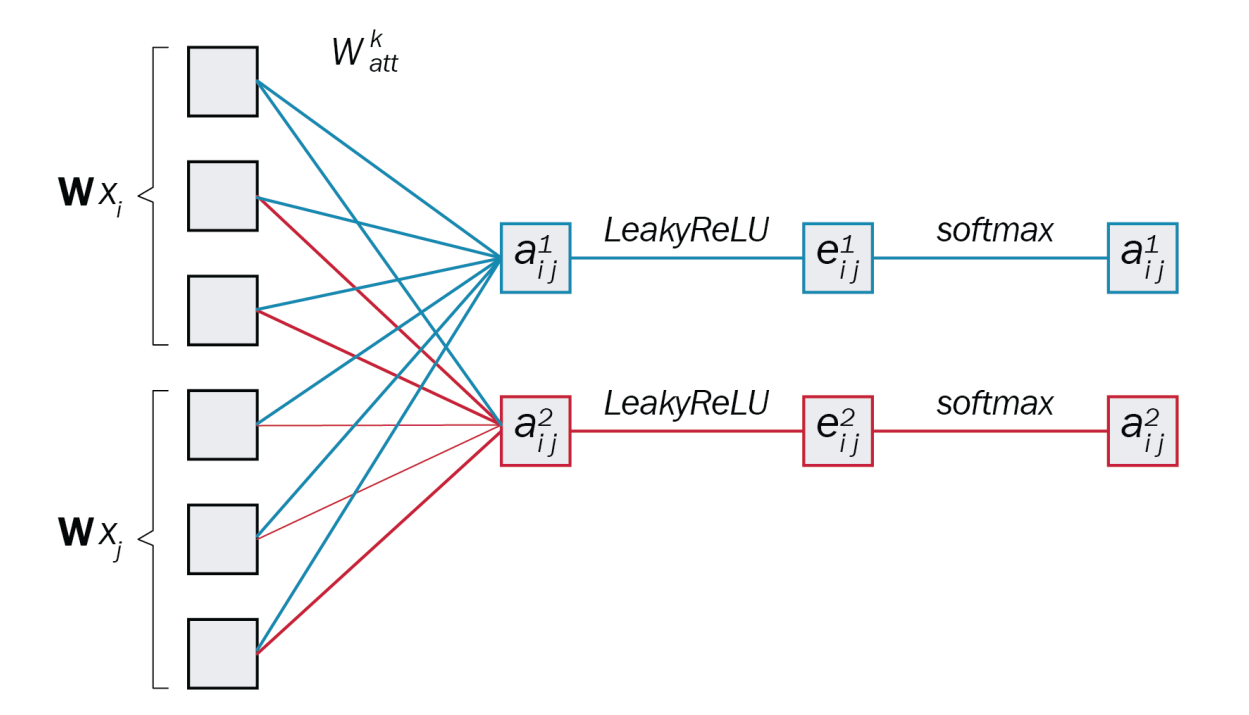

In [32]:
import torch
import numpy as np
np.random.seed(0)

# 은닉 차원의 수
d_out = 2

# 인접 행렬 A (5개의 노드 간 연결 관계를 나타냄)
A = np.array([
    [1, 1, 0, 0, 1],
    [1, 1, 1, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 1, 1, 1],
    [1, 0, 0, 1, 1]
])
print('인접 행렬 A')
print(A)

# 특징 행렬 input X (5개의 노드, 각 노드는 4차원 특징을 가짐)
X = np.random.uniform(-1, 1, (5, 4))
print('\n특징 행렬 X')
print(X)

# 가중치 행렬 W (크기: 은닉 차원의 수 x 입력 특징 차원)
W = np.random.uniform(-1, 1, (d_out, X.shape[1]))
print('\n가중치 행렬 W')
print(W)

# Attention 가중치 행렬 (크기: 1 x (은닉 차원의 수 * 2))
W_att = np.random.uniform(-1, 1, (1, d_out * 2))
print('\nAttention 가중치 행렬')
print(W_att)

# 인접 행렬에서 시작 노드 Src(i)와 끝노드 Target(j) 분리
src, target = np.where(A > 0)

# 노드의 특성 변환 (X @ W.T 를 통해 은닉 차원으로 변환)
Wh_i = (X @ W.T)[src]  # 시작 노드 i의 변환된 특징 벡터
Wh_j = (X @ W.T)[target]  # 끝 노드 j의 변환된 특징 벡터

# 그래프 어텐션 계수 a_ij 계산
# 두 노드 벡터를 연결(concat)한 후 Attention 가중치를 적용
print('\nAttention 계수')
e_ij = W_att @ np.concatenate([Wh_i, Wh_j], axis=1).T  # 연결된 노드 특징에 대해 가중치 적용
print(e_ij)

인접 행렬 A
[[1 1 0 0 1]
 [1 1 1 0 0]
 [0 1 1 1 0]
 [0 0 1 1 1]
 [1 0 0 1 1]]

특징 행렬 X
[[ 0.09762701  0.43037873  0.20552675  0.08976637]
 [-0.1526904   0.29178823 -0.12482558  0.783546  ]
 [ 0.92732552 -0.23311696  0.58345008  0.05778984]
 [ 0.13608912  0.85119328 -0.85792788 -0.8257414 ]
 [-0.95956321  0.66523969  0.5563135   0.7400243 ]]

가중치 행렬 W
[[ 0.95723668  0.59831713 -0.07704128  0.56105835]
 [-0.76345115  0.27984204 -0.71329343  0.88933783]]

Attention 가중치 행렬
[[ 0.04369664 -0.17067612 -0.47088878  0.54846738]]

Attention 계수
[[-0.17255837  0.3352311   0.73739915 -0.34005436  0.16773511 -1.1176524
   0.54119792 -0.7441896   0.11877087 -0.96200138 -0.09904092  0.72555418
  -0.40084592 -0.3154835   0.5091116 ]]


# 활성화 함수

In [33]:
def leaky_relu(x):
    return np.maximum(0.01*x, x)
# 정규화 되지 않은 unnormalized attention score"
e_ij = leaky_relu(e_ij)
e_ij

array([[-0.00172558,  0.3352311 ,  0.73739915, -0.00340054,  0.16773511,
        -0.01117652,  0.54119792, -0.0074419 ,  0.11877087, -0.00962001,
        -0.00099041,  0.72555418, -0.00400846, -0.00315483,  0.5091116 ]])

# e_ij를 인접행렬 크기로 변환 E

In [25]:
E = np.zeros(A.shape)
E[src,target] = e_ij[0]
A, E

(array([[1, 1, 0, 0, 1],
        [1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0],
        [0, 0, 1, 1, 1],
        [1, 0, 0, 1, 1]]),
 array([[-0.00172558,  0.3352311 ,  0.        ,  0.        ,  0.73739915],
        [-0.00340054,  0.16773511, -0.01117652,  0.        ,  0.        ],
        [ 0.        ,  0.54119792, -0.0074419 ,  0.11877087,  0.        ],
        [ 0.        ,  0.        , -0.00962001, -0.00099041,  0.72555418],
        [-0.00400846,  0.        ,  0.        , -0.00315483,  0.5091116 ]]))

# 소프트맥스 정규화

In [30]:
def softmax(x, axis):
    e = np.exp(x-np.expand_dims(np.max(x, axis=axis), axis))
    return e/ np.expand_dims(np.sum(e, axis=axis), axis)

# 정규화돈 attention weight계수
alpha_ij = softmax(E, 1)
alpha_ij

array([[0.15388796, 0.21554753, 0.15415373, 0.15415373, 0.32225705],
       [0.19283731, 0.22883072, 0.19134362, 0.19349418, 0.19349418],
       [0.17132789, 0.29435223, 0.17005762, 0.19293437, 0.17132789],
       [0.16514426, 0.16514426, 0.16356319, 0.16498078, 0.34116751],
       [0.17607549, 0.1767827 , 0.1767827 , 0.17622586, 0.29413325]])

# 그래프 어텐션 행렬 H

In [31]:
# 출력 노드 출력
H = A.T @ alpha_ij @ X @ W.T
H

array([[0.88942255, 0.96797484],
       [0.96104761, 0.94670836],
       [0.94805583, 0.90860807],
       [0.886925  , 0.99286195],
       [0.79909933, 1.11141636]])

# PyTorch Geometric 으로 GAT구현

In [2]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='.', name = "Cora")
data = dataset[0]

Processing...
Done!


In [23]:
import torch
torch.manual_seed(1)

import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, GATConv
from torch.nn import Linear, Dropout

def accuracy(y_pred, y_true):
    return torch.sum(y_pred == y_true)/len(y_true)

class GAT(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
        
    def forward(self, x, edge_index):
        h = F.dropout(x, p = 0.6, training=self.training)
        h = self.gat1(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p = 0.6, training=self.training)
        h = self.gat2(h, edge_index)
        return F.log_softmax(h, dim=1)
    
    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.005, weight_decay=0.01)
        
        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
            loss.backward()
            optimizer.step()
            
            if(epoch%10 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | train loss:{loss:.3f} | train acc: {acc*100:>5.2f}% | val loss: {val_loss:.2f} | val accury:{val_acc*100:5.2f}')
                
    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

In [24]:
gat = GAT(dataset.num_features, 32, dataset.num_classes)
gat

GAT(
  (gat1): GATv2Conv(1433, 32, heads=8)
  (gat2): GATv2Conv(256, 7, heads=1)
)

In [25]:
gat.fit(data, epochs=100)

Epoch   0 | train loss:1.969 | train acc: 15.00% | val loss: 1.96 | val accury:11.80
Epoch  10 | train loss:0.353 | train acc: 94.29% | val loss: 0.89 | val accury:74.40
Epoch  20 | train loss:0.182 | train acc: 96.43% | val loss: 1.01 | val accury:70.20
Epoch  30 | train loss:0.194 | train acc: 97.86% | val loss: 0.95 | val accury:71.00
Epoch  40 | train loss:0.186 | train acc: 99.29% | val loss: 0.95 | val accury:70.80
Epoch  50 | train loss:0.213 | train acc: 97.14% | val loss: 0.90 | val accury:73.00
Epoch  60 | train loss:0.199 | train acc: 98.57% | val loss: 0.91 | val accury:71.40
Epoch  70 | train loss:0.153 | train acc: 99.29% | val loss: 0.91 | val accury:70.00
Epoch  80 | train loss:0.139 | train acc: 99.29% | val loss: 0.92 | val accury:72.60
Epoch  90 | train loss:0.157 | train acc: 99.29% | val loss: 0.95 | val accury:72.00
Epoch 100 | train loss:0.159 | train acc: 98.57% | val loss: 0.95 | val accury:71.40


In [26]:
gat.test(data)

tensor(0.7790)

# CiteSeer

In [28]:
dataset = Planetoid(root='.', name='CiteSeer')
data = dataset[0]
data

Processing...
Done!


Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])

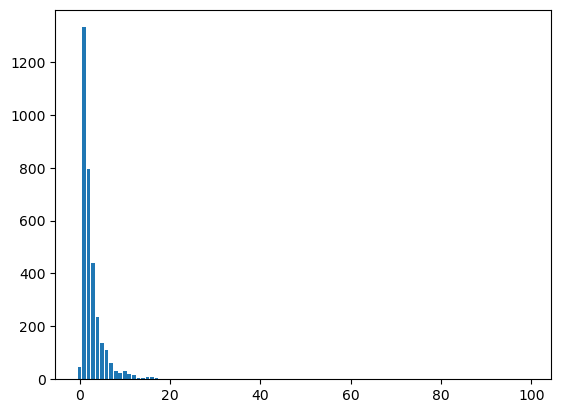

In [29]:
import matplotlib.pyplot as plt
from torch_geometric.utils import degree
from collections import Counter

degrees = degree(dataset[0].edge_index[0]).numpy()

numbers = Counter(degrees)
plt.bar(numbers.keys(), numbers.values());

In [30]:
gat_city = GAT(dataset.num_features, 16, dataset.num_classes)
gat_city.fit(data, epochs=100)

Epoch   0 | train loss:1.803 | train acc: 15.83% | val loss: 1.81 | val accury:16.60
Epoch  10 | train loss:0.175 | train acc: 97.50% | val loss: 1.10 | val accury:63.40
Epoch  20 | train loss:0.128 | train acc: 95.83% | val loss: 1.11 | val accury:62.60
Epoch  30 | train loss:0.166 | train acc: 96.67% | val loss: 1.12 | val accury:62.60
Epoch  40 | train loss:0.147 | train acc: 99.17% | val loss: 1.15 | val accury:62.80
Epoch  50 | train loss:0.170 | train acc: 95.83% | val loss: 1.07 | val accury:64.80
Epoch  60 | train loss:0.129 | train acc: 98.33% | val loss: 1.14 | val accury:62.80
Epoch  70 | train loss:0.104 | train acc: 100.00% | val loss: 1.14 | val accury:65.40
Epoch  80 | train loss:0.124 | train acc: 98.33% | val loss: 1.11 | val accury:65.20
Epoch  90 | train loss:0.137 | train acc: 99.17% | val loss: 1.08 | val accury:63.40
Epoch 100 | train loss:0.091 | train acc: 100.00% | val loss: 1.13 | val accury:63.20


In [31]:
gat_city.test(data)

tensor(0.6990)

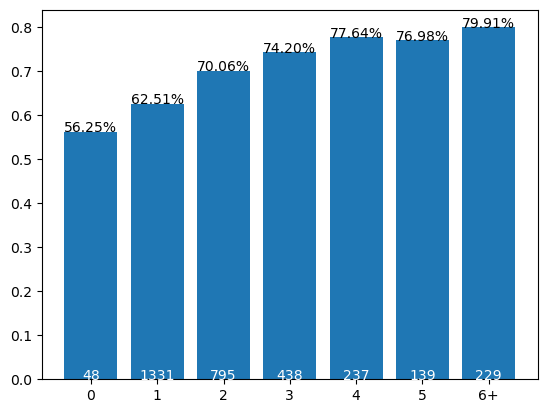

In [36]:
import numpy as np
out = gat_city(data.x, data.edge_index)
degrees = degree(data.edge_index[0]).numpy()

accuracies = []
sizes = []

for i in range(6):
    mask = np.where(degrees == i)[0]
    accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
    sizes.append(len(mask))
    
mask = np.where(degrees > 6)[0]
accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
sizes.append(len(mask))

plt.bar(['0','1','2','3','4','5','6+'], accuracies)
for i in range(0, 7):
    plt.text(i, accuracies[i], f'{accuracies[i]*100:.2f}%', ha='center', color='black')
for i in range(0, 7):
    plt.text(i, accuracies[i]//2, sizes[i], ha='center', color='white')